In [4]:
import os
import gzip
import shutil
import pickle
import random
from pathlib import Path
from collections import defaultdict
from itertools import combinations, combinations_with_replacement, product, chain
import urllib

# Visualization and data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

# Proteomics libraries
import pyopenms as pms
from pyopenms import MSExperiment, MzMLFile
from pyteomics import mzml
from pyteomics.mass.mass import std_aa_mass
import spectrum_utils as su

In [5]:
# !pip install seaborn

# A deep dive into limitations of modification searching for DIA data

Data-Dependent Acquisition (DDA) and Data-Independent Acquisition (DIA) are the two most common acqisition methods in mass spectrometry. Especially in recent years DIA has become more popular for its ability to be highly reproducible and potentially be more sensitive. The data from DIA is however much more complex to interpret and needs sophisticated data analysis methods to reach this potential.

DDA vs. DIA: Fundamental Differences

Data-Dependent Acquisition (DDA) generally selects ions based on their intensity from an MS1 scan. Based on the m/z ions are isolated within a specified isolation windows, these precursor ions are then fragmented (MS2), and the resulting spectra are used to identify peptides. This method focuses on the most abundant ions in each scan cycle. This is shown in the first figure where the DDA acquisition cycle (bottom) alternates between a full scan (MS1) and targeted MS2 scans of selected ions. It is important to note that DDA still has isolation windows wide enough to isolate multiple precursors of different peptidoform origin.

In contrast, Data-Independent Acquisition (DIA) collects data across a wider range of m/z values without prior ion selection. Instead, DIA is preconfigured to specific isolation windows, fragmenting all ions in these preconfigured isolation windows. DIA allows for more comprehensive and unbiased acquisition, capturing information from all ions, which increases sensitivity and data completeness compared to DDA. However, the complexity of the data makes it harder to assign spectra to specific peptides due to overlapping signals and unknown origins of signals.

![dda_vs_dia](https://github.com/CompOmics/EUPA_2025_DIA/blob/main/workshop/img/1_ddavsdia.png?raw=true)

Open Modification Searches: Challenges

In both DDA and DIA, the identification of modified peptides is challenging. These challenges become even more pronounced as the number of modifications included in the search space increases, with ambiguity growing disproportionately for each additional modification. Furthermore, when searching for a large number of modifications there are not only issues with identification ambiguity, but also the search space introduces computational challenges.

![issues search](img/2_issues_search.png)

In DDA, the identification is typically more straightforward since it aims to isolate a single peptidoform for fragmentation. This selective nature helps narrow down the search space. However, in DIA, all ions in a given m/z window are fragmented simultaneously, leading to more complex spectra. The broader acquisition means more overlapping peaks and increased ambiguity in the interpretation of modification sites, as the data includes multiple co-eluting peptides.

Computational Issues and Ambiguities

The third figure highlights one significant computational issue: ambiguity in peptide identification during open modification searches. For example, a peptide sequence, such as EEIFGPVM[Oxidation]QLIK and EEIFGP[Oxidation]VQPLFK. Both sequences are equally valid, but resolving them requires careful consideration of retention time and ion fragmentation patterns. Which can be (partly) resolved with predictions, but as we will see later this is still very difficult for DIA data.

![issues search](img/3_resolving_ambiguity.png)

In [6]:
# List of URLs to download and extract
urls = [
    "https://genesis.ugent.be/uvpublicdata/workshop_2025_eupa/LFQ_Orbitrap_AIF_Human_01.mzML.gz",
    "https://genesis.ugent.be/uvpublicdata/workshop_2025_eupa/LFQ_Orbitrap_DDA_Human_01.mzML.gz"
]

for url in urls:
    # Determine filenames
    output_gz = Path(url.split("/")[-1])
    output_mzml = output_gz.with_suffix("")  # Remove '.gz'

    print(f"Processing: {output_gz.name}")

    # Step 1: Download the file
    with urllib.request.urlopen(url) as response, open(output_gz, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

    # Step 2: Decompress the file
    with gzip.open(output_gz, 'rb') as f_in, open(output_mzml, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

    # Optional: remove the .gz file
    output_gz.unlink()

    print(f"Extracted: {output_mzml.resolve()}\n")

Processing: LFQ_Orbitrap_AIF_Human_01.mzML.gz
Extracted: C:\Users\robbi\OneDrive - UGent\Documents\2025\Conferences\eupa\analysis\EUPA_2025_DIA\workshop\LFQ_Orbitrap_AIF_Human_01.mzML

Processing: LFQ_Orbitrap_DDA_Human_01.mzML.gz
Extracted: C:\Users\robbi\OneDrive - UGent\Documents\2025\Conferences\eupa\analysis\EUPA_2025_DIA\workshop\LFQ_Orbitrap_DDA_Human_01.mzML



# Visualize MS1 & MS2

For this workshop we will use samples from human K562 cells. The data were acquired on a Thermo Orbitrap QE HF-X instrument in both DDA and DIA (AIF) mode with 8 m/z staggered windows. More details about the dataset can be found in [Van Puyvelde et al.](https://www.nature.com/articles/s41597-022-01216-6).
![data source](img/4_datasource_bvp.png)

First we will have a look at the special nature of DIA data where the isolation window is set much wider and the isolation windows follow up each other in a iterative fashion. This is important as likely many more precursors are within the same isolation window and the isolation is consistent between experiments and cover the full m/z range of interest.

Lets first read the .mzML file of the run:

In [16]:
# Path to your mzML file
mzml_file = 'LFQ_Orbitrap_AIF_Human_01.mzML'

def read_mzmzl(mzml_file,break_after_n_spectra=200000):
    ms1_to_scan = {}
    ms1_to_ms2 = {}
    
    # Open the mzML file and read the spectra
    with mzml.MzML(mzml_file) as reader:
        for idx, spectrum in enumerate(reader):
            if spectrum['ms level'] == 1:
                ms_1_scan_nr = int(spectrum.get('id', '').split('scan=')[1].split()[0])
                ms1_to_scan[ms_1_scan_nr] = spectrum
            elif spectrum['ms level'] == 2:
                ms_2_scan_nr = int(spectrum.get('id', '').split('scan=')[1].split()[0])
                if ms_1_scan_nr in ms1_to_ms2.keys():
                    ms1_to_ms2[ms_1_scan_nr][ms_2_scan_nr] = spectrum
                else:
                    ms1_to_ms2[ms_1_scan_nr] = {}
                    ms1_to_ms2[ms_1_scan_nr][ms_2_scan_nr] = spectrum
    
            # Only process first n spectra for performance
            if idx > break_after_n_spectra:
                break
    return ms1_to_scan, ms1_to_ms2

ms1_to_scan, ms1_to_ms2 = read_mzmzl(mzml_file)

Next we define some helper functions for plotting. There are in total three functions:

1. **get_random_ms_specs** - select a random MS1 and an MS2 (that are "linked") from the read file. Return all relevant information for plotting
2. **get_ms_specs_scan** - based on a specific MS1 and MS2 scan number return the spectra
3. **create_ms_plot** - plot the MS1 and MS2 spectra. For the MS1 indicate the region that is isolated

In [17]:
def get_random_ms_specs(ms1_to_scan,ms1_to_ms2):
    # Select a random MS1 spectrum
    random_ms1 = random.choice(list(ms1_to_scan.keys()))
    ms1_spectrum = ms1_to_scan[random_ms1]
    mz1, intensity1 = np.array(ms1_spectrum['m/z array']), np.array(ms1_spectrum['intensity array'])
    
    # Assuming the precursor information is available in the MS1 spectrum
    precursor_mz1 = ms1_spectrum.get('precursorMz', np.nan)  # Precursor m/z (if available)
    precursor_charge1 = ms1_spectrum.get('precursorCharge', 1)  # Precursor charge (if available)
    
    # Select a random MS2 spectrum related to the random MS1 spectrum
    random_ms2 = random.choice(list(ms1_to_ms2[random_ms1].keys()))
    ms2_spectrum = ms1_to_ms2[random_ms1][random_ms2]
    mz2, intensity2 = np.array(ms2_spectrum['m/z array']), np.array(ms2_spectrum['intensity array'])
    
    # Get the precursor m/z of the MS2 spectrum (for the isolation window)
    precursor_mz2 = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    isolation_width = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

    return mz1, intensity1, ms1_spectrum, random_ms1, mz2, intensity2, ms2_spectrum, random_ms2, precursor_mz2, isolation_width

def get_ms_specs_scan(ms1_to_scan,ms1_to_ms2,ms1_scan,ms2_scan):
    ms1_spectrum = ms1_to_scan[ms1_scan]
    mz1, intensity1 = np.array(ms1_spectrum['m/z array']), np.array(ms1_spectrum['intensity array'])
    
    # Assuming the precursor information is available in the MS1 spectrum
    precursor_mz1 = ms1_spectrum.get('precursorMz', np.nan)  # Precursor m/z (if available)
    precursor_charge1 = ms1_spectrum.get('precursorCharge', 1)  # Precursor charge (if available)
    
    ms2_spectrum = ms1_to_ms2[ms1_scan][ms2_scan]
    mz2, intensity2 = np.array(ms2_spectrum['m/z array']), np.array(ms2_spectrum['intensity array'])
    
    # Get the precursor m/z of the MS2 spectrum (for the isolation window)
    precursor_mz2 = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
    isolation_width = ms2_spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

    return mz1, intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width

def create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width):
    # Plot MS1 spectrum using stem plot (vertical lines for each peak)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15/2, 6/2))
    
    markerline, stemlines, baseline = ax1.stem(mz1, intensity1, basefmt=" ", markerfmt=" ", linefmt='C0-')
    plt.setp(stemlines, 'linewidth', 0.5)
    # Highlight the isolation window around the precursor in MS1
    
    # Highlight the isolation window around the precursor in MS2 (for MS1 plot)
    if not np.isnan(precursor_mz2):
        ax1.axvspan(precursor_mz2 - isolation_width, precursor_mz2 + isolation_width, color='red', alpha=0.5, label='Precursor Isolation Window')
    
    ax1.set_xlabel('m/z')
    ax1.set_ylabel('Intensity')
    ax1.set_title(f'MS1 Spectrum: Scan {random_ms1}')
    ax1.grid(True)
    ax1.legend()
    
    markerline, stemlines, baseline = ax2.stem(mz2, intensity2, basefmt=" ", markerfmt=" ", linefmt='C1-')
    plt.setp(stemlines, 'linewidth', 0.5)
    ax2.set_xlabel('m/z')
    ax2.set_ylabel('Intensity')
    ax2.set_title(f'MS2 Spectrum: Scan {random_ms2}')
    ax2.grid(True)
    plt.show()

Next we will fetch a random spectrum MS1 and associated MS2 and visualize them:

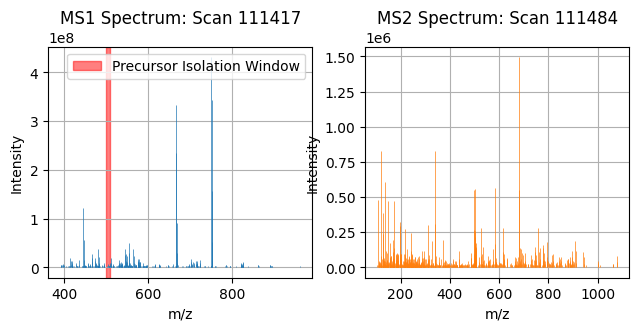

In [18]:
mz1, intensity1, ms1_spectrum, random_ms1, mz2, intensity2, ms2_spectrum, random_ms2, precursor_mz2, isolation_width = get_random_ms_specs(ms1_to_scan,ms1_to_ms2)
create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width)

As this is DIA data we collect many more MS2 spectra consecutively, so for the MS1 previously defined lets go through the next 50 MS2 spectra:

Could not find the associated spectrum, skipping ...


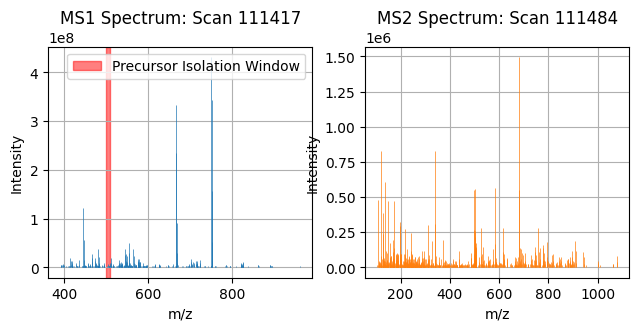

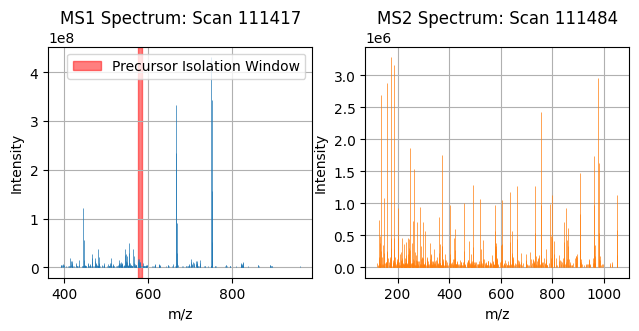

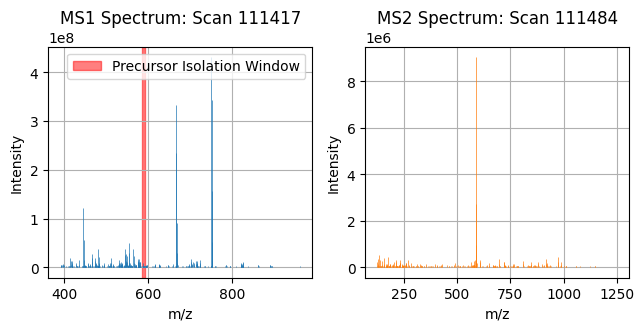

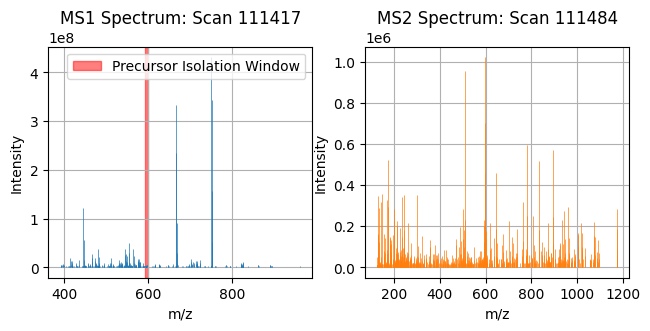

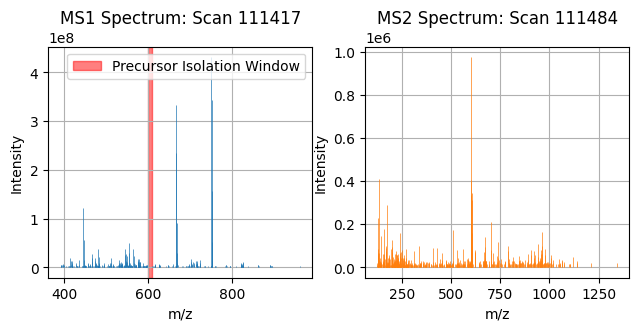

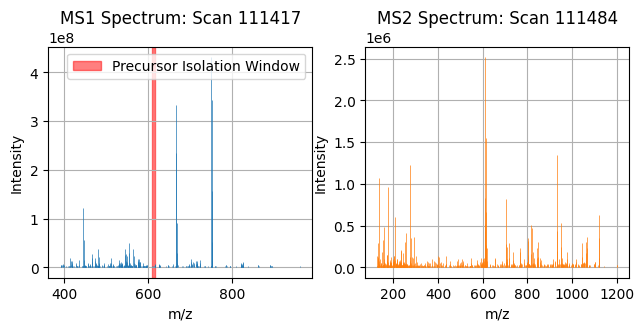

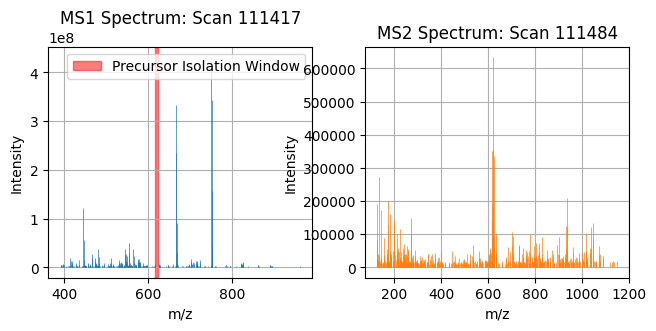

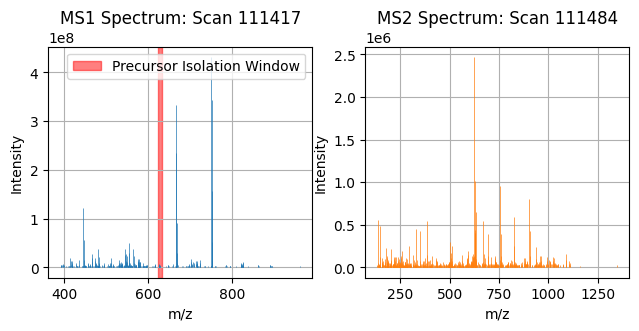

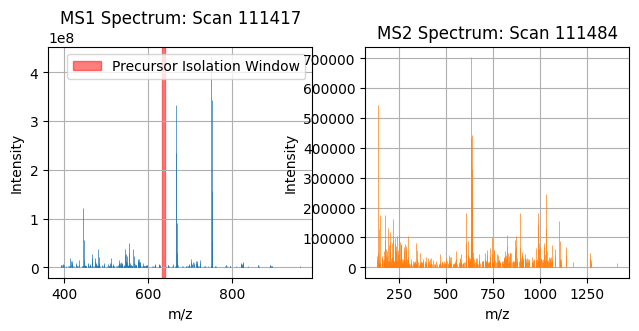

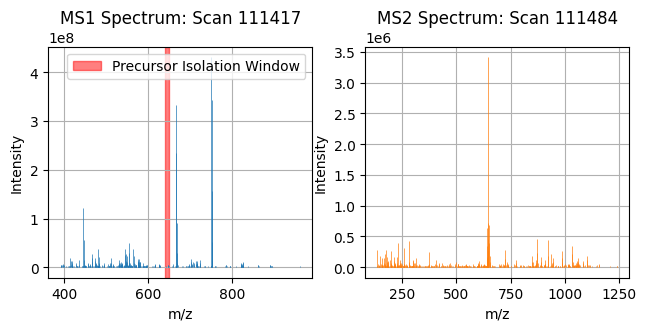

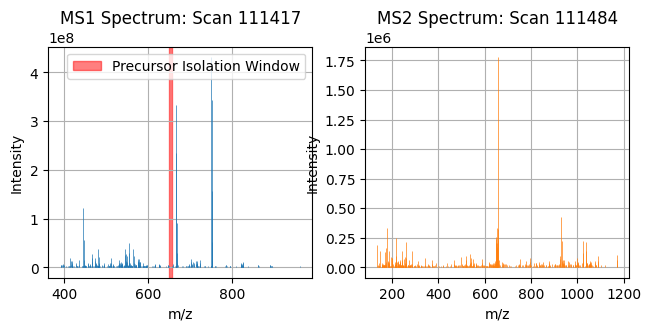

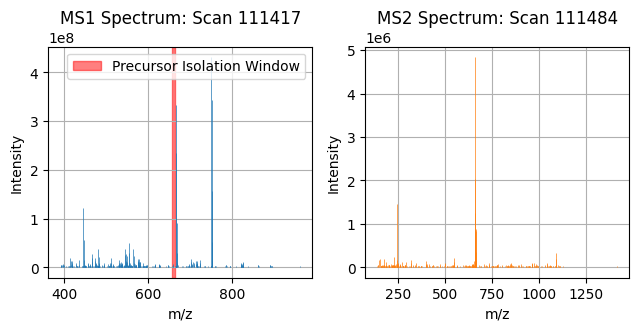

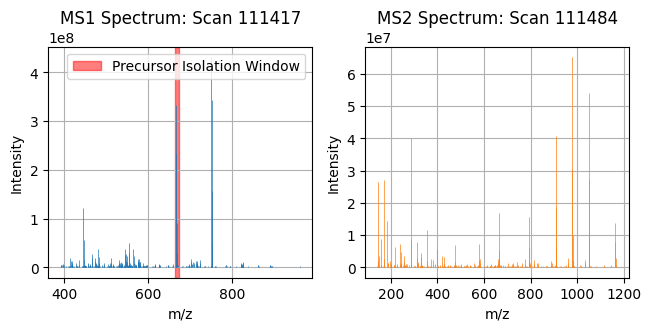

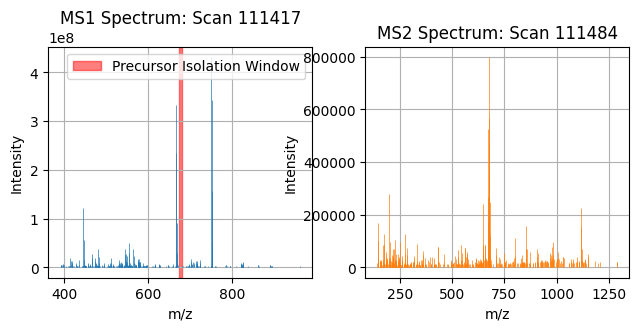

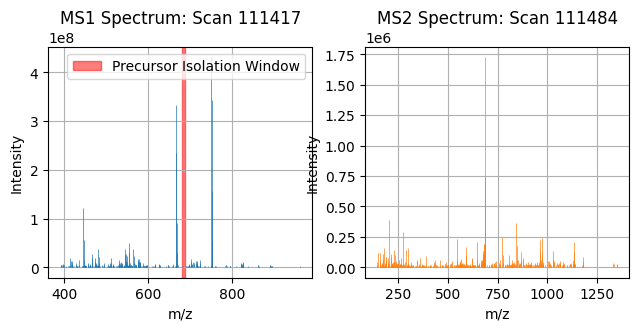

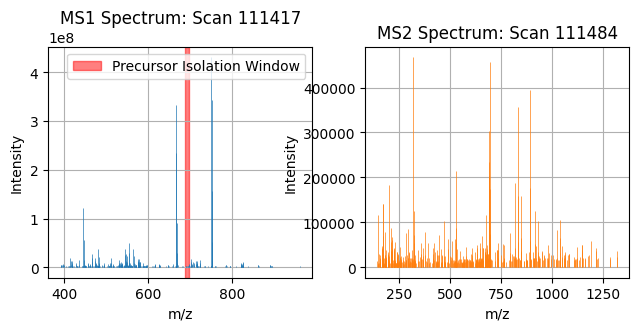

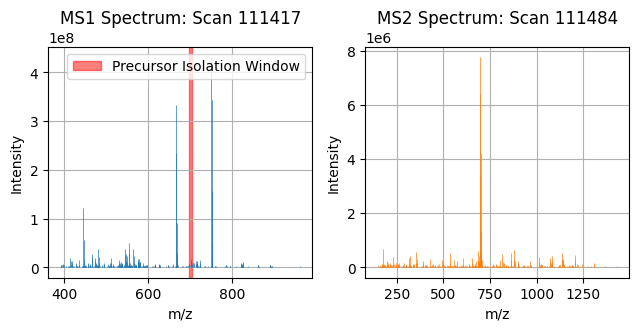

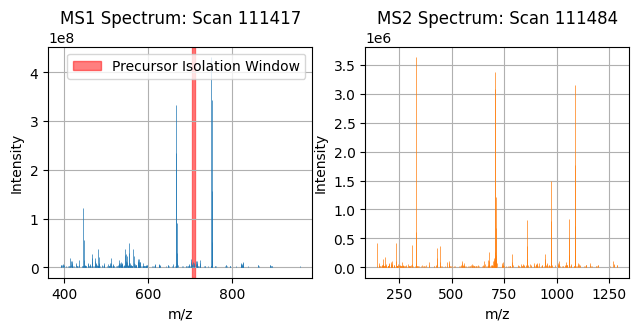

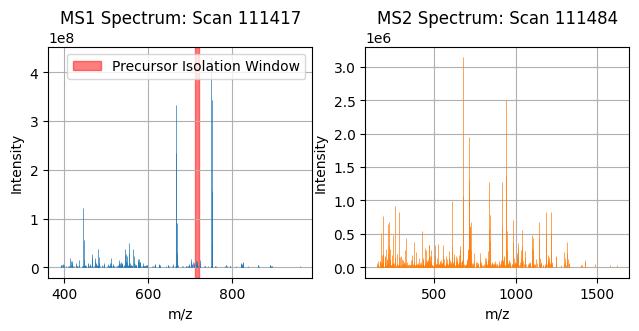

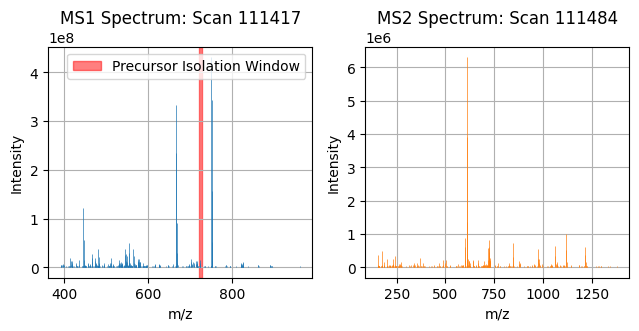

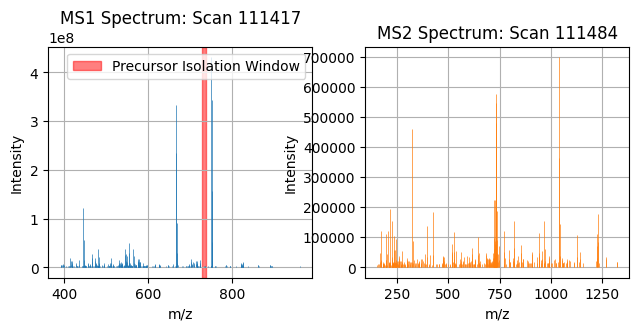

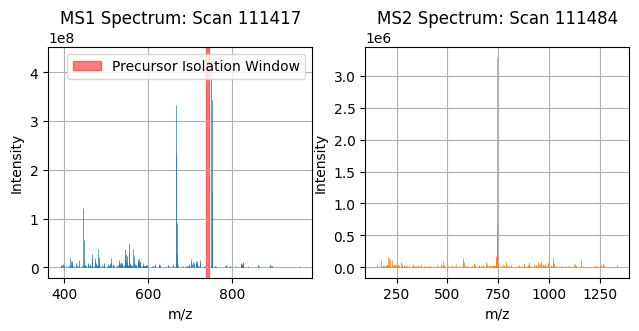

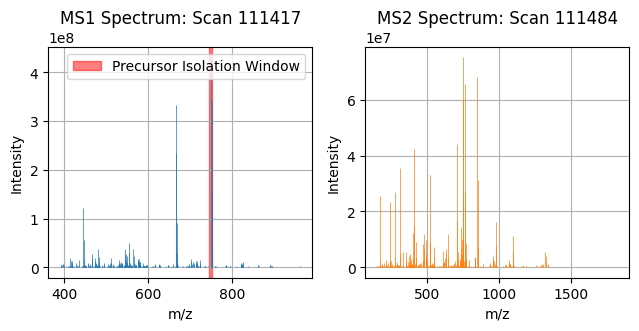

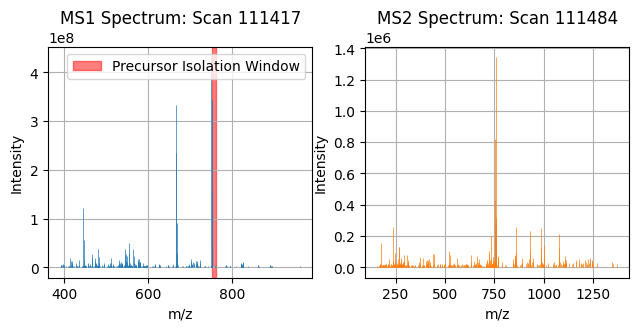

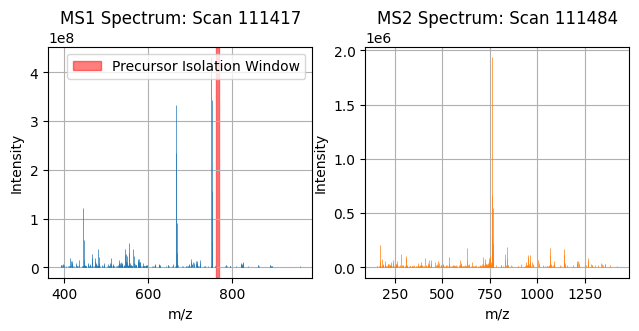

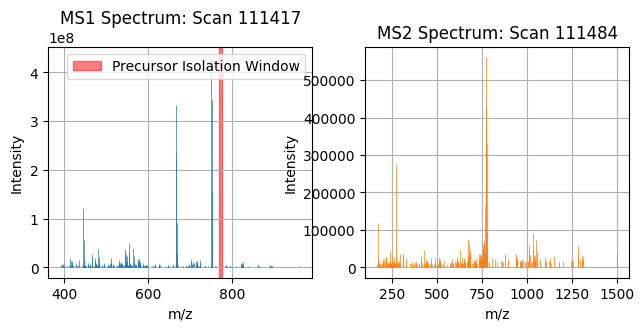

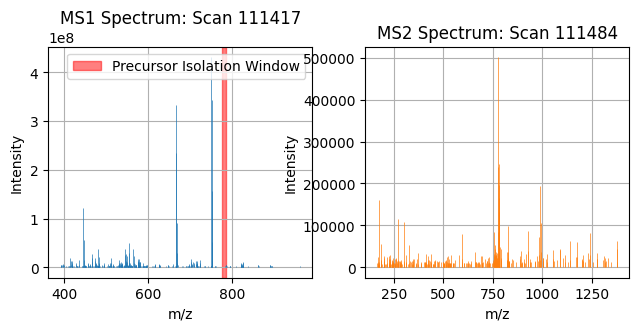

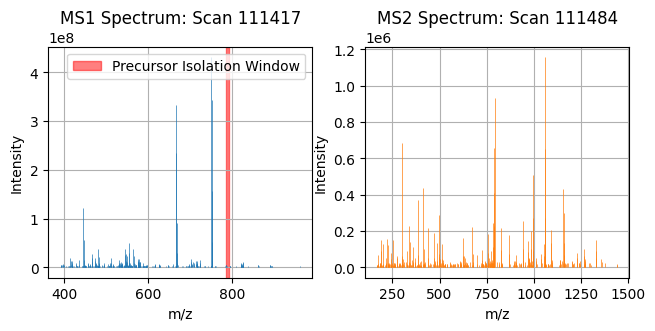

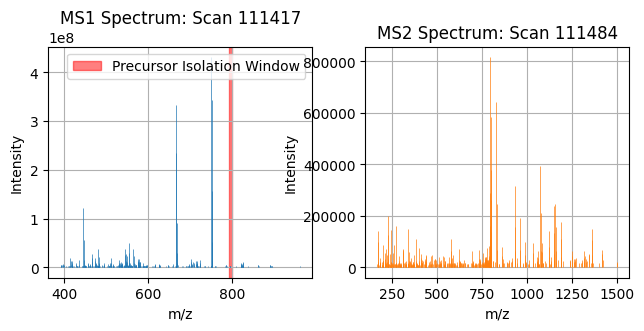

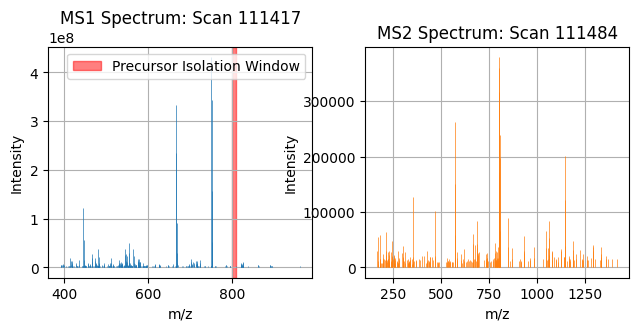

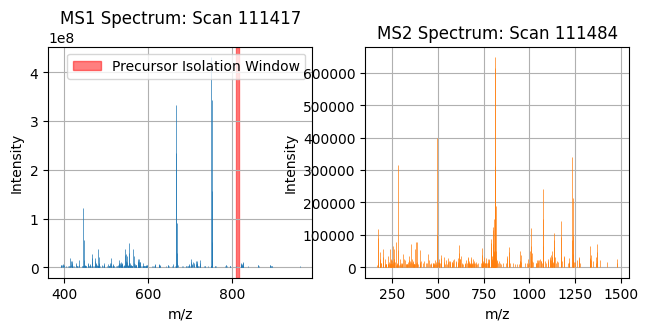

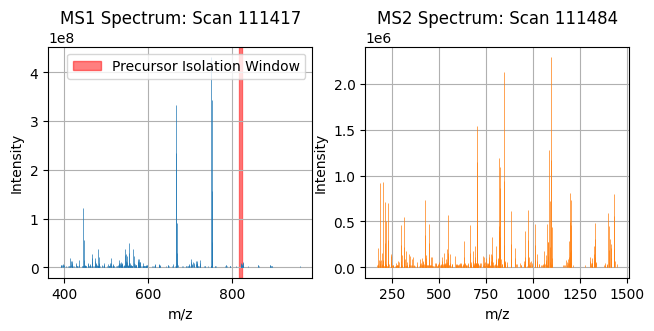

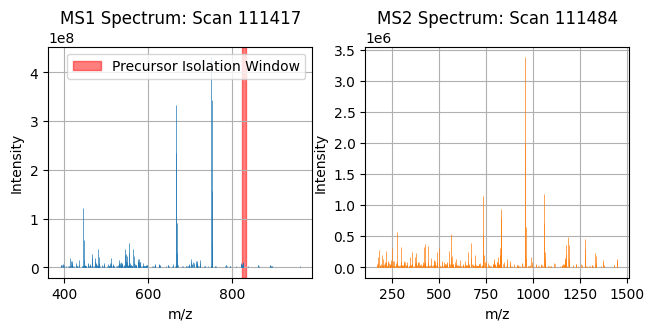

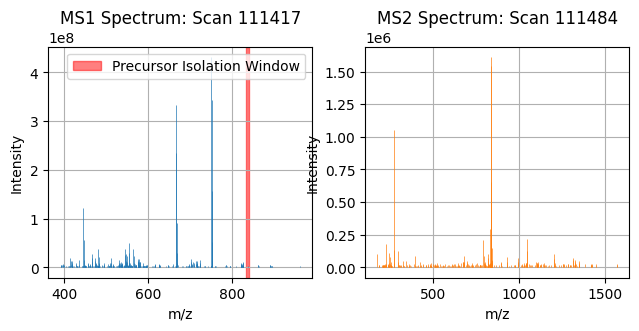

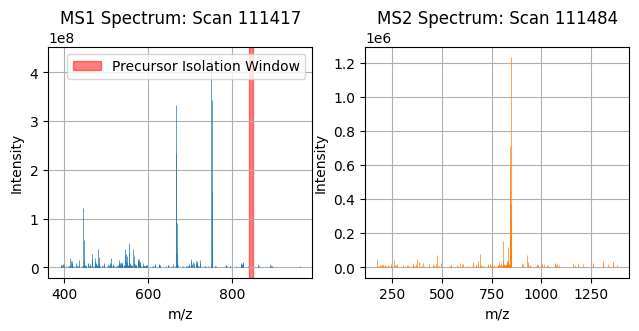

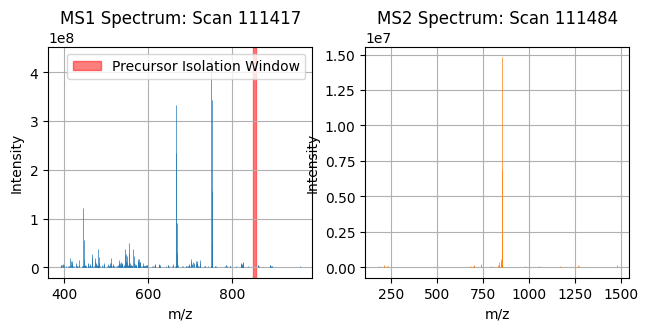

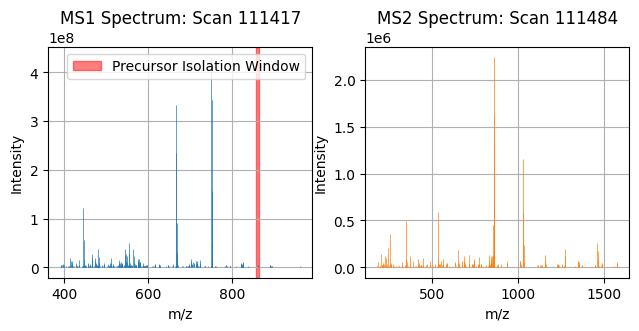

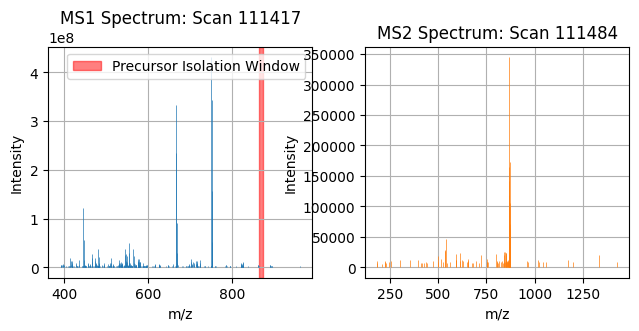

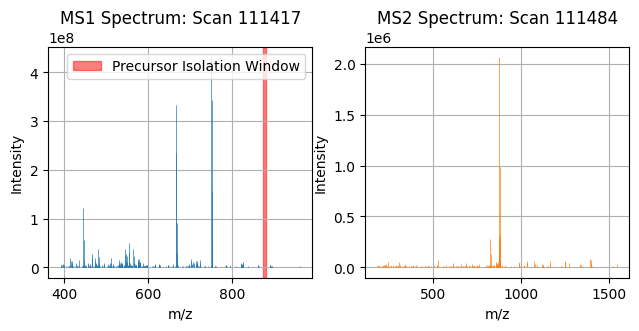

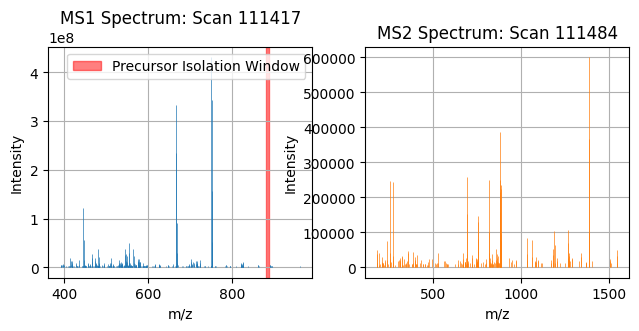

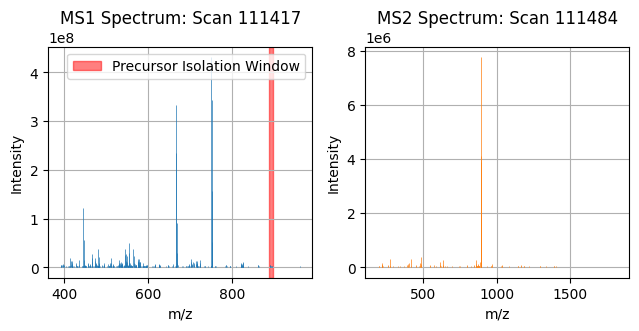

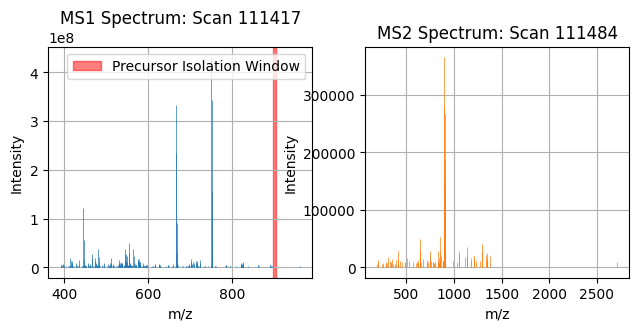

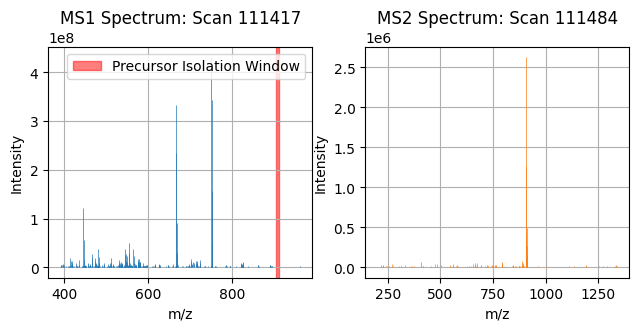

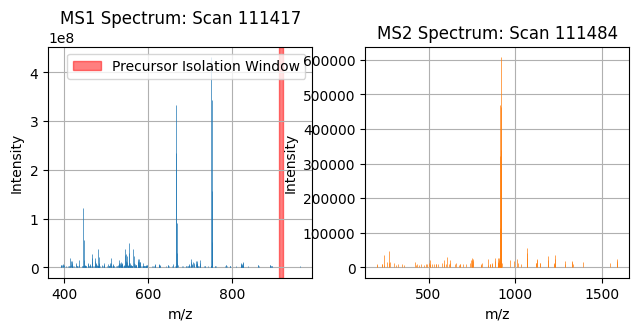

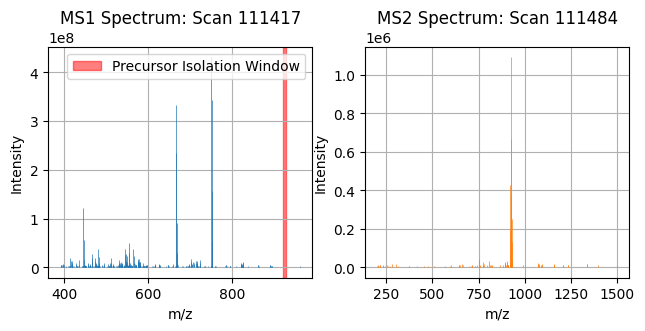

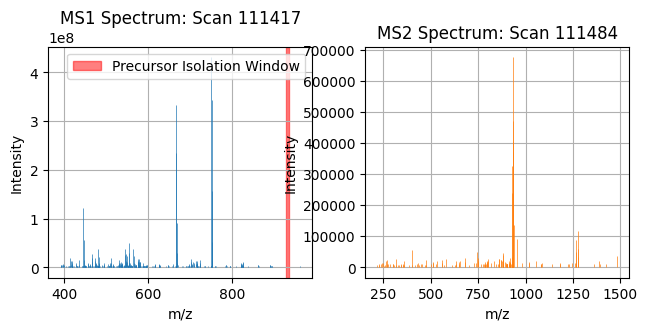

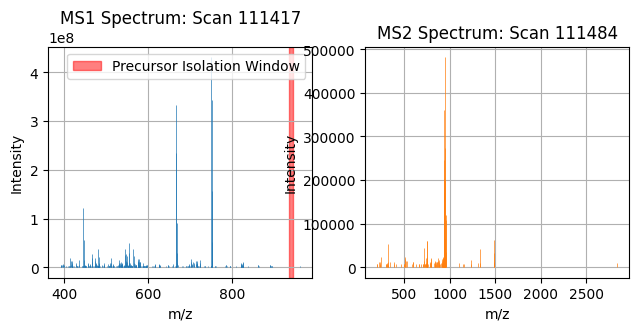

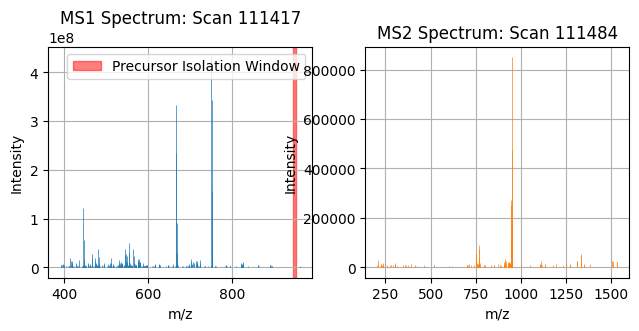

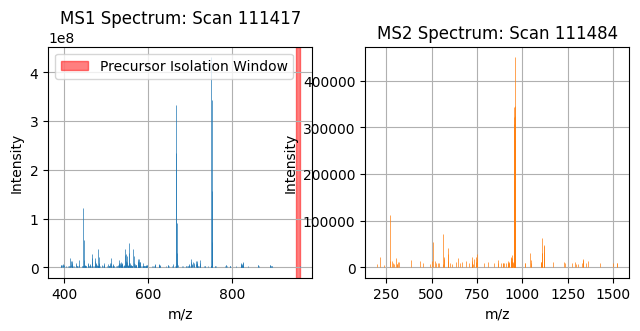

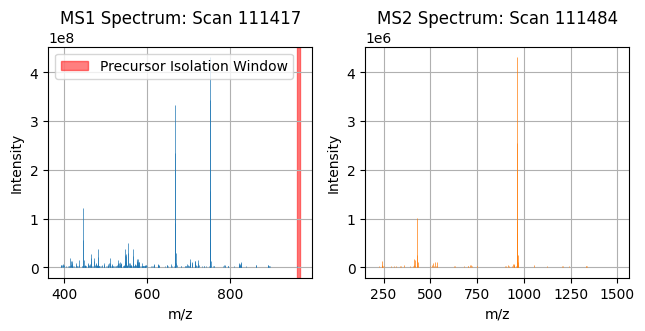

In [19]:
next_n_spectra = 25
for i in range(0,next_n_spectra):
    try:
        mz1, intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width = get_ms_specs_scan(ms1_to_scan,ms1_to_ms2,random_ms1,random_ms1+i)
    except KeyError:
        print("Could not find the associated spectrum, skipping ...")
    create_ms_plot(mz1,intensity1, ms1_spectrum, mz2, intensity2, ms2_spectrum, precursor_mz2, isolation_width)

# Count peaks in MS1 and MS2

![count](https://media1.tenor.com/m/CSYSqLuo6fwAAAAC/sesame-street-muppets.gif)

In [ ]:
def process_file(mzml_path):
    exp = MSExperiment()
    MzMLFile().load(mzml_path, exp)
    num_peaks = []

    for s in tqdm(exp.getSpectra()):
        if s.getMSLevel() == 1:
            ms1_spectrum = s.get_peaks()[0]
            continue

        lower_val = (
            s.getPrecursors()[0].getMZ()
            - s.getPrecursors()[0].getIsolationWindowLowerOffset()
        )
        upper_val = (
            s.getPrecursors()[0].getMZ()
            + s.getPrecursors()[0].getIsolationWindowUpperOffset()
        )

        try:
            num_peaks.append(
                sum([1 for mz in ms1_spectrum if lower_val < mz < upper_val])
            )
        except:
            continue

    return num_peaks

In [ ]:
def process_file(mzml_path, ms1_mode=True):
    num_peaks = []
    ms1_spectrum = None

    # Open mzML file using pyteomics
    with mzml.MzML(mzml_path) as reader:
        for spectrum in tqdm(reader):
            # Process MS1 spectra
            if spectrum['ms level'] == 1:
                ms1_spectrum = spectrum['m/z array']
                continue

            # Process MS2 spectra
            if spectrum['ms level'] == 2 and ms1_spectrum is not None and ms1_mode:
                precursor_mz = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window target m/z']
                offset = spectrum['precursorList']['precursor'][0]['isolationWindow']['isolation window lower offset']

                lower_val = precursor_mz - offset
                upper_val = precursor_mz + offset

                # Count the number of peaks from MS1 spectrum within the isolation window
                num_peaks.append(
                    sum([1 for mz in ms1_spectrum if lower_val < mz < upper_val])
                )
            if spectrum['ms level'] == 2 and not ms1_mode:
                num_peaks.append(
                    sum([1 for mz in spectrum['m/z array']])
                )
                
    return num_peaks


In [ ]:
mzml_file_dia = "./LFQ_Orbitrap_AIF_Human_01.mzML"
mzml_file_dda = "./LFQ_Orbitrap_DDA_Human_01.mzML"

num_peaks_dia_ms1 = process_file(mzml_file_dia)
num_peaks_dda_ms1 = process_file(mzml_file_dda)

num_peaks_dia_ms2 = process_file(mzml_file_dia, ms1_mode=False)
num_peaks_dda_ms2 = process_file(mzml_file_dda, ms1_mode=False)

In [ ]:
num_peaks_dict = {}

num_peaks_dict["LFQ_Orbitrap_AIF_Human_01.mzML_ms1"] = num_peaks_dia_ms1
num_peaks_dict["LFQ_Orbitrap_DDA_Human_01.mzML_ms1"] = num_peaks_dda_ms1

num_peaks_dict["LFQ_Orbitrap_AIF_Human_01.mzML_ms2"] = num_peaks_dia_ms2
num_peaks_dict["LFQ_Orbitrap_DDA_Human_01.mzML_ms2"] = num_peaks_dda_ms2

In [ ]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML_ms1"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML_ms1"

plt.hist(
    num_peaks_dict[dda_key],
    bins=list(range(0, 260)),
    color="blue",
    alpha=0.5,
    label="DDA Orbitrap",
)
plt.hist(
    num_peaks_dict[dia_key],
    bins=list(range(0, 260)),
    color="red",
    alpha=0.5,
    label="DIA Orbitrap",
)

plt.title("MS1 peaks in a spectrum")

plt.legend()
plt.xlabel("Peaks in spectrum (#)")
plt.ylabel("Frequency (#)")
plt.tight_layout()
plt.show()

In [ ]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML_ms2"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML_ms2"

plt.hist(
    num_peaks_dict[dda_key],
    bins=list(range(0, 260)),
    color="blue",
    alpha=0.5,
    label="DDA Orbitrap",
)
plt.hist(
    num_peaks_dict[dia_key],
    bins=list(range(0, 260)),
    color="red",
    alpha=0.5,
    label="DIA Orbitrap",
)

plt.title("MS1 peaks in a spectrum")

plt.legend()
plt.xlabel("Peaks in spectrum (#)")
plt.ylabel("Frequency (#)")
plt.tight_layout()
plt.show()

# Ambiguity - multi interpretation

In [ ]:
amino_acid_masses = {
    # Standard amino acids
    "A": 71.03711,
    "R": 156.10111,
    "N": 114.04293,
    "D": 115.02694,
    "C": 103.00919,
    "E": 129.04259,
    "Q": 128.05858,
    "G": 57.02146,
    "H": 137.05891,
    "I": 113.08406,
    "L": 113.08406,
    "K": 128.09496,
    "M": 131.04049,
    "F": 147.06841,
    "P": 97.05276,
    "S": 87.03203,
    "T": 101.04768,
    "W": 186.07931,
    "Y": 163.06333,
    "V": 99.06841,

    # Modified residues (accurate total masses)
    "C[Carbamidomethyl]": 160.03065,     # 103.00919 + 57.02146
    "M[Oxidation]": 147.03540,           # 131.04049 + 15.99491
    "H[Oxidation]": 153.05382,           # 137.05891 + 15.99491
    "Q[Pyro-glu]": 111.03203,            # 128.05858 − 17.02655
    "E[Pyro-glu]": 111.03203,            # 129.04259 − 18.01056
    "W[Oxidation]": 202.07422,           # 186.07931 + 15.99491
    "N[Deamidated]": 115.02695,          # 114.04293 + 0.98402
    "Q[Deamidated]": 129.04260,          # 128.05858 + 0.98402
    "S[Phospho]": 166.99836,             # 87.03203 + 79.96633
    "T[Phospho]": 181.01398,             # 101.04768 + 79.96633
    "Y[Phospho]": 243.02966,             # 163.06333 + 79.96633
    "K[Acetyl]": 170.10552,              # 128.09496 + 42.01056
    "K[Methyl]": 142.11061,              # 128.09496 + 14.01565
    "K[Dimethyl]": 156.12626,            # 128.09496 + 28.03130
    "K[Trimethyl]": 170.14191,           # 128.09496 + 42.04695
    "K[Propionyl]": 185.11642,           # 128.09496 + 57.02146
    "K[Butyryl]": 199.13031,             # 128.09496 + 71.03535
    "K[Formyl]": 156.10572,              # 128.09496 + 28.01076
    "K[Malonyl]": 186.11146,             # 128.09496 + 58.01650
    "K[Succinyl]": 200.12535,            # 128.09496 + 72.03039
    "R[Methyl]": 170.11676,              # 156.10111 + 14.01565
    "R[Dimethyl]": 184.13241,            # 156.10111 + 28.03130
    "R[Trimethyl]": 198.14806,           # 156.10111 + 42.04695
}

all_masses = {**amino_acid_masses}

# Converting to a sorted list of masses for easier indexing
sorted_masses = sorted(all_masses.items(), key=lambda x: x[1])
amino_acid_deltas = [mass for name, mass in sorted_masses]
amino_acid_deltas_names = [name for name, mass in sorted_masses]

In [ ]:
def calculate_pairwise_distances(mzs, amino_acid_deltas, tolerance=0.005, max_mz=300.0):
    mzs = np.array(mzs)
    if len(mzs) < 2:  # Ensure there are at least two m/z values to compare
        return np.zeros(len(amino_acid_deltas), dtype=int)
    mz_diffs = np.abs(mzs[:, np.newaxis] - mzs)
    mz_diffs = np.triu(mz_diffs, k=1)
    mz_i, mz_j = np.where((mz_diffs > 0) & (mz_diffs <= max_mz))
    if not mz_i.size:  # No valid differences found
        return np.zeros(len(amino_acid_deltas), dtype=int)
    mz_diffs = mz_diffs[mz_i, mz_j]
    comparison = np.abs(mz_diffs[:, np.newaxis] - amino_acid_deltas) <= tolerance
    return np.sum(comparison, axis=0)

def bin_and_sum_intensities(pairs):
    bins = np.arange(0, 300.005, 0.005)
    intensity_sums = np.zeros(len(bins))
    for mz1, mz2, diff, intensity_sum in pairs:
        idx = int(diff / 0.005)
        intensity_sums[idx] += intensity_sum
    return intensity_sums

def process_file(mzml_path, amino_acid_deltas):
    exp = MSExperiment()
    MzMLFile().load(mzml_path, exp)
    spectra = [
        (s.get_peaks()[0], s.get_peaks()[1])  # select_top_peaks
        for s in exp.getSpectra()
        if s.getMSLevel() == 2
    ]
    
    results_matrix = []
    for mzs, intensities in tqdm(spectra):
        if len(mzs) > 1:
            results_matrix.append(calculate_pairwise_distances(mzs, amino_acid_deltas))
        else:
            results_matrix.append(
                np.zeros(len(amino_acid_deltas), dtype=int)
            )  # Ensure consistent shape
    return results_matrix

In [ ]:
results_dict = {}
files = [
    "./LFQ_Orbitrap_AIF_Human_01.mzML",
    "./LFQ_Orbitrap_DDA_Human_01.mzML"
]
result_dir = "./"

for file in files:
    result = process_file(file, amino_acid_deltas)
    result = pd.DataFrame(result)
    result.columns = amino_acid_deltas_names
    results_dict[os.path.basename(file)] = result

In [ ]:
dia_key = "LFQ_Orbitrap_AIF_Human_01.mzML"
dda_key = "LFQ_Orbitrap_DDA_Human_01.mzML"

# Initialize the figure and axis for the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Lists to store values for plotting the distributions
dia_values = []
dda_values = []
labels = []

for i in range(20, len(amino_acid_masses.keys()) + 1):
    selected_cols = list(amino_acid_masses.keys())[0:i]

    # Calculate the sums of the selected columns
    dia_count_all = results_dict[dia_key][selected_cols].sum(axis=1)
    dda_count_all = results_dict[dda_key][selected_cols].sum(axis=1)

    # Filter sums greater than 10 and collect values
    dia_values.append(dia_count_all[dia_count_all > 10].values)
    dda_values.append(dda_count_all[dda_count_all > 10].values)

    labels.append(str(i))

# Plotting boxplots
positions_dia = [x - 0.2 for x in range(20, len(amino_acid_masses.keys()) + 1)]
positions_dda = [x + 0.2 for x in range(20, len(amino_acid_masses.keys()) + 1)]
central_positions = [x for x in range(20, len(amino_acid_masses.keys()) + 1)]

ax.boxplot(
    dia_values,
    positions=positions_dia,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor="red"),
    medianprops=dict(color="black"),
    showfliers=False,
)
ax.boxplot(
    dda_values,
    positions=positions_dda,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor="blue"),
    medianprops=dict(color="black"),
    showfliers=False,
)

# Custom legend
legend_elements = [
    Patch(facecolor="red", edgecolor="black", label="DIA"),
    Patch(facecolor="blue", edgecolor="black", label="DDA"),
]
ax.legend(handles=legend_elements, loc="upper left")

# Setting the plot limits, labels, title, and x-ticks
ax.set_ylim(0, 4000)
ax.set_xlabel("Number of Selected Columns")
ax.set_ylabel("Summed Values")
ax.set_title("Empirical Differential of Summed Values Over Columns")
ax.set_xticks(central_positions)
ax.set_xticklabels(labels, rotation=45)

# Show the plot
plt.show()

# Search space size 

In [ ]:
def tryptic_digest_pyopenms(
    file_path,
    min_len=5,
    max_len=50,
    missed_cleavages=2,
    decoy_method="reverse",
    decoy_prefix="rev_",
    seq_types=["original", "decoy"],
):
    # Read the FASTA file
    fasta = pms.FASTAFile()
    entries = []
    fasta.load(file_path, entries)

    # Set up the enzyme digestion
    digestor = pms.ProteaseDigestion()
    digestor.setEnzyme("Trypsin")
    digestor.setMissedCleavages(missed_cleavages)

    peptides = []
    for entry in entries:
        # Process both original and decoy sequences
        for seq_type in seq_types:
            if seq_type == "original":
                protein_sequence = str(entry.sequence)
            else:
                if decoy_method == "reverse":
                    protein_sequence = str(entry.sequence)[::-1]
                elif decoy_method == "scramble":
                    seq_list = list(str(entry.sequence))
                    random.shuffle(seq_list)
                    protein_sequence = "".join(seq_list)
                else:
                    raise ValueError(
                        "Invalid decoy method. Choose 'reverse' or 'scramble'."
                    )

            protein_name = entry.identifier.split()[
                0
            ]  # Adjust based on your FASTA format

            # Perform the tryptic digest
            result = []
            digestor.digest(pms.AASequence.fromString(protein_sequence), result)

            for peptide in result:
                peptide_sequence = str(peptide.toString())
                len_pep_seq = len(peptide_sequence)
                start = protein_sequence.find(peptide_sequence)
                end = start + len_pep_seq
                if "X" in peptide_sequence:
                    continue
                if len_pep_seq >= min_len and len_pep_seq <= max_len:
                    if seq_type == "original":
                        peptides.append(
                            (
                                protein_name,
                                start,
                                end,
                                f"{protein_name}|{start}|{end}",
                                peptide_sequence,
                            )
                        )
                    else:
                        peptides.append(
                            (
                                f"{decoy_prefix}{protein_name}",
                                start,
                                end,
                                f"{decoy_prefix}{protein_name}|{start}|{end}",
                                peptide_sequence,
                            )
                        )
    return peptides
    
def calculate_possibilities(possibilities,max_mods=3):
    N = len(possibilities)  # Total number of positions
    total = 0

    # Iterate over the number of positions that can vary (0 to 3)
    for k in range(0, max_mods+1):
        # Generate all combinations of positions that can vary
        for varying_positions in combinations(range(N), k):
            # Calculate the product of possibilities for the chosen positions
            product = 1
            for pos in varying_positions:
                product *= possibilities[pos]
            # Add this product to the total sum
            total += product

    return total

def modification_list_to_dict(all_amino_acids, modifications_search_space):
    modification_dict = defaultdict(list)
    for modification, amino_acids in modifications_search_space:
        for aa in amino_acids:
            modification_dict[aa].append(modification)

    for aa in all_amino_acids:
        modification_dict[aa].insert(0, "")

    modification_dict = dict(modification_dict)
    return modification_dict

def apply_modifications(
    peptides, modifications, charges=[2, 3, 4, 5], max_var_mods=3, max_len=30, min_len=7
):
    unique_peptides = set([p[-1] for p in peptides])
    tot_num = 0
    tot_num_fragments = 0

    for idx, peptide_seq in enumerate(unique_peptides):
        if len(peptide_seq) > max_len or len(peptide_seq) < min_len:
            continue
        all_pos = [len(modifications[aa]) - 1 for aa in peptide_seq]
        poss = calculate_possibilities(all_pos, max_mods=max_var_mods) * len(charges)
        tot_num += poss
        tot_num_fragments += poss * len(peptide_seq) * 2

    return tot_num

In [ ]:
# Your modification data
modifications_search_space = [
    ("[Oxidation]", ["M"]),  # , "P"
    ("[OxidationP]", ["P"]),  # , "P"
    ("[Carbamidomethyl]", ["C"]),
    ("[Alkyl]", ["C"]),
    ("[DeamidationN]", ["N"]),
    ("[DeamidationQ]", ["Q"]),
    ("[PhosphorylationS]", ["S"]),
    ("[PhosphorylationT]", ["T"]),
    ("[PhosphorylationY]", ["Y"]),
    ("[Nitrosyl]", ["C"]),
    ("[OxidationC]", ["C"]),
    ("[Methyl]", ["K"]),
    ("[MethylR]", ["R"]),
    ("[Dimethyl]", ["K"]),
    ("[DimethylR]", ["R"]),
    ("[Trimethyl]", ["K"]),
    ("[CitrullinationR]", ["R"]),
    ("[Propionyl]", ["K"]),
    ("[Butyryl]", ["K"]),
    ("[Malonyl]", ["K"]),
    ("[Succinyl]", ["K"]),
    ("[Glutarylation]", ["K"]),
    ("[Crotonyl]", ["K"]),
    ("[Hydroxyisobutyryl]", ["K"]),
    ("[Biotin]", ["K"]),
    ("[GG]", ["K"]),
    ("[NitroY]", ["Y"]),
]


charge_min_range = range(1, 3)
charge_max_range = [2]
maximum_length_range = [35]
max_var_mods_range = [1]
missed_cleavages = [2]
num_var_mods = range(0, len(modifications_search_space[0:5]))

combinations_df = product(
    charge_min_range,
    charge_max_range,
    maximum_length_range,
    max_var_mods_range,
    missed_cleavages,
    num_var_mods,
)

df = pd.DataFrame(
    combinations_df,
    columns=[
        "charge_min",
        "charge_max",
        "maximum_length",
        "max_var_mods",
        "missed_cleavages",
        "num_var_mods",
    ],
)

In [ ]:
fasta_analyze = "human_22032024.fasta"

# Define all standard amino acids
all_amino_acids = set(
    "ABCDEFGHIKLMNPQRSTUVWXY"
)  # 20 standard amino acids + additional ones that can be in the fasta, they are ignored if they are not in there

search_space_list = []
for idx,r in tqdm(df.iterrows()):
    i = r["num_var_mods"]
    # Read peptides from fasta using a tryptic digest function
    peptides = tryptic_digest_pyopenms(
        fasta_analyze,
        min_len=6,
        max_len=r["maximum_length"],
        missed_cleavages=int(r["missed_cleavages"]),
    )

    modification_dict = modification_list_to_dict(
        all_amino_acids, modifications_search_space[0:i+1]
    )

    # Apply modifications to peptides
    all_peptidoforms = apply_modifications(
        peptides,
        modification_dict,
        charges=list(range(r["charge_min"], r["charge_max"])),
        max_var_mods=r["max_var_mods"],
    )
    print(f"Total number of unique peptidoforms: {all_peptidoforms}")
    search_space_list.append(all_peptidoforms)
    
df["search_space"] = search_space_list
df.to_csv("data/human_searchpace.csv")

In [ ]:
sub_df_search_space = df[df["charge_min"] == 1]

In [ ]:
plt.scatter(sub_df_search_space["num_var_mods"], sub_df_search_space["search_space"],s=20,alpha=0.5)
plt.plot(sub_df_search_space["num_var_mods"], sub_df_search_space["search_space"])
plt.show()

# Prediction comparison

In [ ]:
df_tr = pd.read_csv("prosit_ptm_2020.csv")
df_tr.fillna("",inplace=True)

In [ ]:
# Separate unmodified and modified peptides
df_unmod = df_tr[df_tr["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod = df_tr[df_tr["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged = pd.merge(df_mod, df_unmod[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged["delta_tr"] = df_merged["tr"] - df_merged["tr_unmod"]
df_merged = df_merged.sort_values(by="seq")

In [ ]:
df_vp = df_exploded.dropna(subset=["delta_tr", "mod_types"])

# Limit to top modifications for clarity
top_mods = df_vp["mod_types"].value_counts().nlargest(10).index
df_vp = df_vp[df_vp["mod_types"].isin(top_mods)]

# Function to identify outliers by IQR for each group
def filter_outliers(group):
    q1 = group["delta_tr"].quantile(0.25)
    q3 = group["delta_tr"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Return group without outliers
    return group[(group["delta_tr"] >= lower_bound) & (group["delta_tr"] <= upper_bound)]

# Filter outliers for violin plot only
df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True)

sns.set_style("whitegrid")

# Calculate median ΔRT per modification type
mod_order = df_vp_filtered.groupby("mod_types")["delta_tr"].median().sort_values(ascending=False).index

plt.figure(figsize=(9, 5.0))

# Pass the sorted order to violinplot
sns.violinplot(x="mod_types", y="delta_tr", data=df_vp_filtered, order=mod_order)

# Optional: show all points with swarmplot (uncomment if desired)
# sns.swarmplot(x="mod_types", y="delta_tr", data=df_vp, order=mod_order, color='k', size=2, alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.xlabel("Modification Type")
plt.ylabel("ΔRT (min)")
plt.tight_layout()
plt.savefig("img/rt_shift.svg")
plt.show()

In [ ]:
df = pd.read_csv("report.tsv",sep="\t")
df_filtered = df[df["Q.Value"] < 0.01]
df_tr = pd.read_csv("prosit_ptm_2020.csv")

df_grad_length = abs(df["iRT"].max()-df["iRT"].min())
df_grad_length_ptm = abs(df_tr["tr"].max()-df_tr["tr"].min())

diann_predictions = df_filtered["RT"] - df_filtered["Predicted.RT"]

In [ ]:
df_tr.fillna("",inplace=True)

# Separate unmodified and modified peptides
df_unmod = df_tr[df_tr["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod = df_tr[df_tr["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged = pd.merge(df_mod, df_unmod[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged["delta_tr"] = df_merged["tr"] - df_merged["tr_unmod"]

# Optional: sort for readability
df_merged = df_merged.sort_values(by="seq")

# Step 2: Extract only the modification types from the modification string
# Example: "18|Methyl|9|Carbamidomethyl" -> ["Methyl", "Carbamidomethyl"]
def extract_mod_types(mod_str):
    if not mod_str:
        return []
    parts = mod_str.split('|')
    return [parts[i] for i in range(1, len(parts), 2)]

# Create a column of modification lists
df_merged["mod_types"] = df_merged["modifications"].apply(extract_mod_types)
df_merged = df_merged[df_merged["mod_types"].apply(len) == 1].copy()
df_merged["mod_types"] = [mt[0] for mt in df_merged["mod_types"]]

In [ ]:
# Example: Using df_merged with columns "delta_tr" and "mod_types"
values_col = (df_merged["delta_tr"]) / df_grad_length_ptm * 100
df_merged["adjusted_delta_tr"] = values_col  # Create a new column for easier plotting

selected_mods = ["Methyl", "Propionyl", "Dimethyl", "Crotonyl"]
# Plot KDE for each mod_type group
for mod_type in selected_mods:
    subset = df_merged[df_merged["mod_types"] == mod_type]
    sns.kdeplot(subset["adjusted_delta_tr"], bw_adjust=0.5, fill=True, alpha=0.1, label=mod_type)

sns.kdeplot(diann_predictions, bw_adjust=0.5, color='blue', fill=True, alpha=0.8,  label='Identifications "unmodified"')
plt.xlim(-10,30)
plt.legend()
plt.xlabel('Relative retention time difference (%)')
plt.ylabel('Density')

plt.legend(title='Modification Types')
plt.savefig("img/retention_time_prediction_real_exp.svg")
plt.show()